# RNA folding

In the examples below, the secondary structure of the RNA strand is plotted with the [draw_rna](https://github.com/DasLab/draw_rna) lib, which can be installed with `pip install draw_rna`.

First of all, we define some useful utility functions 

* to check whether two bases are complementary; here I also include wobble base pairs among the "compatible" nucleotides;
* to obtain a dot-paren notation out of a sequence and a list of pairs;
* to draw an RNA secondary structure by using `draw_rna`; note that the function fails if the secondary structure is "too unphysical", which happens very often with Nussinov's algorithm;
* to print (in an orderly manner) a matrix; this function can be used to debug the codes or have a look at the energy and traceback matrices to better understand how the algorithms work.

In [1]:
import numpy as np
from draw_rna.ipynb_draw import draw_struct

def is_complementary(Si, Sj):
    """Check if two bases can pair."""
    return Si + Sj in ["GC", "CG", "AU", "UA", "GU", "UG"]

def generate_dot_parens(sequence, base_pairs):
    """Return a string with the dot-paren notation of the given secondary structure"""
    dot_parens = [".", ]  * len(sequence)
    for pair in base_pairs:
        dot_parens[pair[0]] = "("
        dot_parens[pair[1]] = ")"
    
    return "".join(dot_parens)

def draw_structure(sequence, dot_parens):
    """Draw the given secondary structure"""
    # we need this try-except block since the lib we use sometimes fail for short strands with weird secondary structures
    try:
        draw_struct(sequence, dot_parens)
    except Exception:
        print("Cannot draw this structure: it probably has a non-physical secondary structure")
        
def print_matrix(M):
    """Print the given matrix using fixed-width columns"""
    print(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            print(f"{M[i,j]:8.3g}", end=' ')
        print()

## Nussinov's algorithm

This is an implementation of the algorithm presented in the lectures. The contribution of each base pair is $-1$, and the traceback phase is carried out by using recursion.

In [2]:
def initialize_nussinov_matrices(N):
    """
    Initialize the dynamic programming matrix for the Nussinov's algorithm.
    The size of the matrix is N x N, where N is the length of the sequence.
    """
    # Initialize the matrix with zeros
    F = np.zeros((N, N), dtype=float)
    T = np.zeros((N, N), dtype=int)  # Traceback matrix
    return F, T

def nussinov_algorithm(sequence):
    """
    Nussinov's algorithm to calculate the optimal secondary structure for a given RNA sequence.
    sequence: A string representing the RNA sequence.
    Returns the table, the optimal energy score, and the traceback matrix.
    """
    N = len(sequence)
    F, T = initialize_nussinov_matrices(N)
    
    # fill the dynamic programming table
    for i in range(N - 1, -1, -1):  # beginning of the subsequence
        for j in range(i + 1, N):  # end of the subsequence            
            # case 1: Base i is unpaired
            F[i, j] = F[i + 1, j]
            T[i, j] = 0  # Traceback: i is unpaired
            
            # case 2: Base i is paired with k
            for k in range(i + 1, j + 1):
                if is_complementary(sequence[i], sequence[k]):
                    energy = F[i + 1, k - 1] - 1  # assume s_{i,k} = -1 for valid pair
                    if k < j: # make sure that we don't go out of bounds
                        energy += F[k + 1, j]
                    if energy < F[i, j]:  # update if this pairing gives better energy
                        F[i, j] = energy
                        T[i, j] = k  # traceback: i is paired with k
    
    # the optimal energy is stored in F[0, n-1]
    return F, F[0, N - 1], T

def traceback(T, sequence, i, j):
    """
    Traceback function to recover the base pairs from the DP matrix.
    """
    P = []  # list to store the base pairs
    
    def recursive_traceback(i, j):
        if i >= j:
            return
        
        k = T[i, j]
        if k == 0:  # i is unpaired
            recursive_traceback(i + 1, j)
        else:  # i is paired with k
            P.append((i, k))
            recursive_traceback(i + 1, k - 1)
            recursive_traceback(k + 1, j)
    
    recursive_traceback(i, j)

    dot_parens = [".", ]  * len(sequence)
    for pair in P:
        dot_parens[pair[0]] = "("
        dot_parens[pair[1]] = ")"
    
    return P, generate_dot_parens(sequence, P)

In [3]:
# Example usage
sequence = "GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA"
F, optimal_energy, T = nussinov_algorithm(sequence)
base_pairs, dot_parens = traceback(T, sequence, 0, len(sequence) - 1)

print(f"Optimal folding energy: {optimal_energy}")
print(f"Base pairs: {base_pairs}")
print(f"Dot-parens: {dot_parens}")

draw_structure(sequence, dot_parens)

Optimal folding energy: -35.0
Base pairs: [(0, 1), (2, 74), (3, 73), (4, 5), (6, 72), (7, 8), (9, 10), (11, 63), (12, 17), (13, 16), (14, 15), (18, 62), (19, 60), (21, 27), (23, 24), (25, 26), (28, 32), (29, 31), (33, 55), (34, 54), (35, 40), (36, 39), (37, 38), (41, 49), (42, 48), (44, 47), (45, 46), (50, 51), (52, 53), (56, 59), (57, 58), (64, 69), (65, 68), (66, 67), (70, 71)]
Dot-parens: ()((()(()()(((()))((.(.()())((.))((((()))((.(())))()()))(())).))((()))()))).
Error occured while drawing RNA 1 0
Cannot draw this structure: it probably has a non-physical secondary structure


## Zuker's algorithm

In the simplified approach below, I make many approximations for the sake of readability and conciseness.

First of all, every stack composed by two compatible base pairs gives an energy of $-2$. Then, I use simple expressions for the hairpin, bulge and interior loop penalties, $F_H(L)$, $F_I(L)$, $F_B(L)$ as a function of the length $L$, which I obtained by (very crudely) fitting the values reported [here](https://rna.urmc.rochester.edu/NNDB/parameter_tables/turner_2004_rnastructure/turner_2004_loop_dg.txt):

$$
\begin{align}
F_H(L) &= 4.8 + 0.19 L - 0.0031 L^2\\
F_B(L) &= 3.5 + 0.16 L - 0.0026 L^2\\
F_I(L) & = 1.3 + 0.14 L - 0.0019 L^2\\
\end{align}
$$

Moreover, there is no asymmetry correction for the internal loops, and mismatches are treated as bulges or internal loops. Finally, as in the original Zuker model, there is no energy penalty associated to $k$-multiloops.

Those are all rather crude approximations, so don't be surprised if the final structure does not look as the one given by "real" codes. However, it will still look not too different (at least in terms of number of base pairs and energy).

About the algorithm itself: the fill-in phase should be rather straightforward, as we simply apply the recursion relations derived in class. The traceback is a bit more complicated, as it requires two traceback matrices $\hat T^W$ and $\hat T^V$: we use $T^V_{i,j}$ if $i,j$ and bonded, $T^W_{i,j}$ otherwise.

The `traceback` function below doesn't use recursion as in the Nussinov's algorithm, but another technique that makes use of a list of subsequences to check, called `to_check`. This list contains the extrema of the subsequence, and the matrix that should be used to traceback. Then, for each element of the list we check whether the next subsequence connected to it is paired or not, and we add the subsequence to `to_check`, together with the information about the traceback matrix to be used.

In [4]:
MIN_LOOP = 3 # minimum length of hairpin loops

def hairpin_loop_energy(seq, i, j):
    """Return the energy penalty of the hairpin loop closed by i,j"""
    L = j - i - 1
    return 4.8 + 0.19 * L - 0.0031 * L**2

def stack_bulge_interior_loop_energy(seq, i, j, k, l):
    """Return the energy of the loop formed by the two base pairs i,j and k,l"""
    # we first check the type of loop
    stack = k == i + 1 and l == j - 1
    bulge_left = k > i + 1
    bulge_right = l < j - 1
    
    if stack: # consecutive base steps: it's a stack loop
        return -2
    elif bulge_left and bulge_right: # interior loop
        L = k - i - 1 + j - l - 1
        energy = 1.3 + 0.14 * L - 0.0019 * L**2
    elif (bulge_left and not bulge_right) or (not bulge_left and bulge_right): # bulge
        L = max(k - i - 1, j - l - 1)
        energy = 3.5 + 0.16 * L - 0.0026 * L**2
    
    return energy
        
def traceback(T_V, T_W, seq):
    """Return the base pairs of the structure identified by the two traceback matrices"""
    N = len(seq)
    
    if T_W[0, N - 1][0] == -1:
        to_check = [(0, N - 1, "V"), ]
    else:
        to_check = [(0, N - 1, "W"), ]
    pairs = []
    
    while to_check:
        i, j, matrix = to_check.pop()
        
        if matrix == "W":
            next_i, next_j = T_W[i, j]
            if next_i != -10:
                if next_i == -1: # i and j are paired, switch to V
                    to_check.append((i, j, "V"))
                elif next_i == next_j: # bifurcation
                    to_check.append((i, next_i, "W"))
                    to_check.append((next_i + 1, j, "W"))
                else: # i or j are unpaired
                    to_check.append((next_i, next_j, "W"))
        else: # matrix V
            pairs.append((i, j)) # i and j are paired
            next_i, next_j = T_V[i, j]
            if next_i != -10:
                if next_i == -1: # hairpin loop, switch to W
                    to_check.append((i + 1, j - 1, "W"))
                elif next_i == next_j: # bifurcation
                    to_check.append((i + 1, next_i, "W"))
                    to_check.append((next_i + 1, j - 1, "W"))
                else: # stack/bulge/interior loop
                    to_check.append((next_i, next_j, "V"))

                
    return pairs

def zuker_algorithm(sequence):
    """Apply Zuker's algorithm to the given sequence"""
    N = len(sequence)
    
    # Initialize matrices V, W, and T (traceback)
    V = np.zeros((N, N))
    W = np.zeros((N, N))
    T_W = np.zeros((N, N), dtype="i, i")  # Initialize the W traceback matrix
    T_W[...] = (-10, -10)
    T_V = np.zeros((N, N), dtype="i, i")  # Initialize the V traceback matrix
    T_V[...] = (-10, -10)
    
    # Initialise the "inaccessible" parts of the matrices to inf
    for i in range(N):
        for j in range(N):
            if j - i - 1 < MIN_LOOP: # nucleotides that are too close cannot pair
                V[i, j] = np.inf
                W[i, j] = np.inf

    # Fill matrices V and W
    for i in range(N - 1, -1, -1):  # beginning of the subsequence
        for j in range(i + MIN_LOOP + 1, N):  # end of the subsequence 
            if is_complementary(sequence[i], sequence[j]):
                E1 = hairpin_loop_energy(sequence, i, j)
                
                # Stack/bulge/interior loop
                E2 = np.inf
                for k in range(i + 1, j - 1):
                    for l in range(k + 1, j):
                        if is_complementary(sequence[k], sequence[l]):
                            energy = stack_bulge_interior_loop_energy(sequence, i, j, k, l) + V[k, l]
                            if energy < E2:
                                E2 = energy
                                kL_min = (k, l)

                # Multiloop
                E3 = np.inf
                for k in range(i + 2, j - 2):
                    energy = W[i + 1, k] + W[k + 1, j - 1]
                    if energy < E3:
                        E3 = energy
                        kM_min = (k, k)

                V[i, j] = min(E1, E2, E3)
                
                # Fill the V traceback matrix
                if V[i, j] == E1:
                    T_V[i, j] = (-1, -1)
                elif V[i, j] == E2:
                    T_V[i, j] = kL_min
                else:
                    T_V[i, j] = kM_min
                    
            else:
                V[i, j] = np.inf
            
            E1 = W[i + 1, j]
            E2 = W[i, j - 1]
            E3 = V[i, j]
            E4 = np.inf
            k_bif = -1
            for k in range(i + 1, j - 1):
                energy = W[i, k] + W[k + 1, j]
                if energy < E4:
                    E4 = energy
                    k_bif = k
                    
            W[i, j] = min(E1, E2, E3, E4)
            
            # Fill the W traceback matrix
            if W[i, j] == E1:
                T_W[i, j] = (i + 1, j) # Indicates i is unpaired
            elif W[i, j] == E2:
                T_W[i, j] = (i, j - 1) # Indicates j is unpaired
            elif W[i, j] == E3:
                T_W[i, j] = (-1, -1) # Indicates i pairs with j
            else:
                T_W[i, j] = (k_bif, k_bif) # Indicates an open bifurcation

    # The minimum free energy of the entire sequence is stored in W[0, N - 1]
    mfe = W[0, N - 1]
    
    # Perform traceback to recover the optimal structure
    structure = traceback(T_V, T_W, sequence)
    
    return mfe, W, V, structure, generate_dot_parens(sequence, structure)

Minimum Free Energy (MFE): -23.666600000000003
Base pairs: [(0, 71), (1, 70), (2, 69), (3, 68), (4, 67), (5, 66), (6, 65), (7, 64), (16, 61), (17, 60), (18, 59), (19, 58), (21, 55), (22, 54), (23, 53), (24, 52), (25, 51), (26, 50), (36, 47), (37, 46), (38, 45), (39, 44)]
Dot-parens: ((((((((........((((.((((((.........((((....))))..))))))..))))..))))))))....


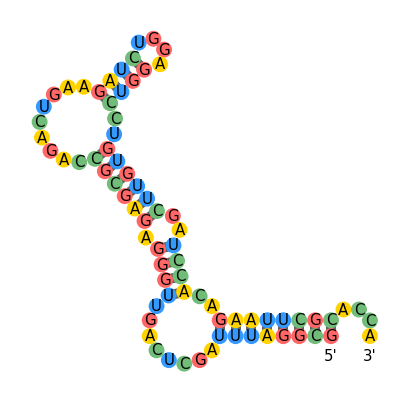

In [5]:
# Example usage
sequence = "GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA"
mfe, W_matrix, V_matrix, structure, dot_parens = zuker_algorithm(sequence)

print(f"Minimum Free Energy (MFE): {mfe}")
print(f"Base pairs: {structure}")
print(f"Dot-parens: {dot_parens}")

draw_structure(sequence, dot_parens)

For reference, I report below the MFE as computed by ViennaRNA (with dangling ends off, energy 19.90 kcal/mol). If you look at the lower part of the structure I hope you agree that, considering the heavy approximations in my code, the agreement is good!
![ViennaRNA's MFE](tRNA_MFE_ViennaRNA.png)

## McCaskill's algorithm

The algorithm implemented here is exactly that presented in class. The implementation is rather straightforward, with two exceptions: when computing $\hat Q$ and $\hat p$, care has to be taken in handling the finiteness of the chain: indeed, some of the recursive relations have to be corrected when dealing with the first and last nucleotides.

In [133]:
import numpy as np

Q_BOND = 1 # statistical weight of a base pair

# The partition function and base-pairing probability computation
def mcCaskill_algorithm(seq):
    N = len(seq)
    Q = np.zeros((N, N))  # Partition function
    Q_bp = np.zeros((N, N)) # Auxiliary partition function
    p = np.zeros((N, N))  # Pairing probability matrix
    
    # Base case: no pairing possible for subsequences of length < 2
    for i in range(N):
        for j in range(N):
            if j - i < 1:
                Q[i, j] = 1.0

    # Fill the partition function matrix
    for i in range(N - 1, -1, -1):  # beginning of the subsequence
        for j in range(i + 1, N):  # end of the subsequence
            if is_complementary(seq[i], seq[j]):
                Q_bp[i, j] = Q[i + 1, j - 1] * Q_BOND
            else:
                Q_bp[i, j] = 0.0
            
            Q[i, j] = Q[i + 1, j]  # i and j are unpaired
            
            # Sum over all possible k where i pairs with j
            for k in range(i + 1, j + 1):
                if is_complementary(seq[i], seq[k]):
                    if k < N - 1: # # handle out-of-bounds case
                        Q[i, j] += Q[k + 1, j] * Q_bp[i, k]
                    else:
                        Q[i, j] += Q_bp[i, k]
    
    # Now compute the base-pairing probabilities
    for i in range(N):
        for j in range(N - 1, -1, -1):
            if j - i > 0 and is_complementary(seq[i], seq[j]):
                Q_prev = 1 if i == 0 else Q[0, i - 1] # handle out-of-bounds case
                Q_next = 1 if j == N - 1 else Q[j + 1, N - 1] # handle out-of-bounds case
                p[i, j] = Q_prev * Q_bp[i, j] * Q_next / Q[0, N - 1]
                
                for h in range(0, i):
                    for k in range(N - 1, j, -1):
                        p[i, j] += p[h, k] * Q[h + 1, i - 1] * Q_bp[i, j] * Q[j + 1, k - 1] / Q[h + 1, k - 1]
    
    return Q, Q_bp, p

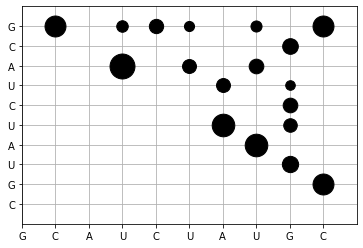

In [134]:
# Example usage
sequence = "GCAUCUAUGC"
Q, Q_bp, p = mcCaskill_algorithm(sequence)

def dot_plot_p(sequence, p):
    """Shows a dot-plot for the base pairing probability"""
    ax = plt.axes()
    # ticks should display the sequence
    ax.set_xticks(list(range(len(sequence))))
    ax.set_xticklabels(list(sequence))
    ax.set_yticks(list(range(len(sequence))))
    ax.set_yticklabels(list(sequence))

    plt.xlim([0, len(sequence)])
    plt.ylim([-1, len(sequence)])

    ax.set_axisbelow(True) # shows the grid below the points
    plt.grid() # toggle the grid
    for i in range(p.shape[0]):
        for j in range(i + 1, p.shape[1]):
            plt.scatter(j, i, s=p[i, j]*2000, c="black")

    plt.gca().invert_yaxis()
    
dot_plot_p(sequence, p)